In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Model for three conduits meeting at a junction and merging into one
from scipy.integrate import odeint
from scipy.optimize import brentq

# Constants - unchanging
rho_w = 1000.#density of water, kg/m^3
rho_i = 900#density of ice, kg/m^3
L_f = 3.34e5#Latent heat of fusion (ice), J/kg
n=3.#ice flow law exponent, unitless
B=5.8e7#Arrhenius parameter, N/m^2 *s^(1/n)
f=0.1#Darcy-Weisbach friction factor, unitless
g = 9.8#gravitational accel, m^2/s
P = 24.*3600. # Period - 1 day in seconds

In [14]:
# Functions
def R(ti,Ri):
    P=24.*3600.
    return Ri*(1.+sin(2.*pi*ti/P)/2.)

def P_wet(A):
    return 2.*sqrt(pi*A)#2.*A**2./pi
def D_H(A):
    return 4.*A/P_wet(A)
def C(A,L):
    return A*sqrt(2.*g/(1+f*L/D_H(A)))
# For a single conduit
def Qh(hi,A,Li):
    return A*sqrt(2.*g*abs(hi)/(1+f*Li/D_H(A)))*sign(hi)
def dy_dt1(y,t,Ri,Zi,A_R,L1):
    Pi = rho_i*g*Zi
    hi = y[0]
    Ai = y[1]
    hout = 0
    Q1 = Qh(hi-hout,Ai,L1)
    dh_dt = (Ri - Q1)/A_R
    Pw = rho_w*g*hi
    dA_dt = f*rho_w/(8*rho_i*L_f)*P_wet(Ai)*(Q1/Ai)**3 - 2.*(1./(n*B))**n*Ai*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    return [dh_dt,dA_dt]

# two conduits
def fh2(h2, h1, C1,C2,C_merg):
    #flow conservation at junction, used to calculate h2 via minimization
    return C1*sqrt(abs(h1-h2))*sign(h1-h2) + C2*sqrt(abs(h1-h2))*sign(h1-h2) - C_merg*sqrt(h2)

def dy_dt2(y,ti,Recharge,Zi,A_R,L1,L2,L_merg):
    #Ri = args[0]
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A_merg = y[3]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C_merg = C(A_merg,L_merg)
    h2 = brentq(fh2, 0,10000, args=(h1,C1,C2,C_merg))
    #print h1,h2
    Q1 = C1*sqrt(abs(h1-h2))*sign(h1-h2)
    Q2 = C2*sqrt(abs(h1-h2))*sign(h1-h2)
    Q_merg = C_merg*sqrt(abs(h2))
    P = 24.*3600.
    dh1_dt = (Recharge*(1.+sin(2.*pi*ti/P)/2.) - Q1 - Q2)/A_R
    Pw1 = rho_w*g*(h1+h2)/2.
    Pw2 = rho_w*g*(h1+h2)/2.
    Pw_merg = rho_w*g*(h2)
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw1)*abs(Pi-Pw1)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw2)*abs(Pi-Pw2)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dAmerg_dt]




In [11]:
# Investigating: minimum hydraulic diameter neccessary
# Changing:


# plots for one conduit model
L1 = 5000.
Ai = linspace(0.0695,0.07,20)
h0 = 500.
Ri = 1.

# Clear variables that change
# Changing ---- 2 conduit below --------
L1=5000 # Length of conduit 1
L2=5000 # Length of conduit 2
L_merg=10000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.3 # Starting Ac of conduit 2
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness

# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

# find the minimum A0 that is physically possible
sol1_list = []
Amin_list = []
for A in Ai:
    sol_test = odeint(dy_dt1,[hi,A],t,args=(Ri,Z,A_R,L))
    sol1_list.append(sol_test)
    if max(sol_test[:,0]) < Z:
        Amin_list.append(A)

    
A_min = min(Amin_list)

sol1= odeint(dy_dt1, [hi,A_min], t, args=(Ri,Z,A_R,L1))
Rec1 = Ri*(1.+sin(2.*pi*t/P)/2.)

# print model run specifications
print 'Single Conduit Model'
print 'Max Head =',max(sol1[:,0]), 'Min Head =',min(sol1[:,0])
print 'Minimum starting A_c =',A_min,'Equilibrium A_c =',sol1[-1,1]
print 'Average Recharge =',Ri,'Moulin Area =',A_R,'Ice thickness =',Z

st = 0 # Start time of plot
tplot = t[st:]/3600.
# Plotting above version of the model
#tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol1[st:,0])
ax2.plot(tplot,Rec1[st:],'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")
# A_c
figure()
plot(tplot,sol1[st:,1])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")


%xdel sol1

NameError: name 'L' is not defined

Two Conduits Merging with the same A0
Minimum A0 = 0.17 Max A0 = 0.8
Conditions: Z = 1000 Ave Recharge = 0.5 A_R = 10 h0 =  100
Two Conduit Model
Max Head = 599.424617292 Min Head = 61.732464746
Average Recharge = 0.5 Moulin Area = 10 Ice thickness = 1000


'\n# CHECK -----\nC1 = C(sol2[:,1],L1)\nC2 = C(sol2[:,2],L2)\nC_merg = C(sol2[:,3],L_merg)\nh2 = []\nfor i,Cblank in enumerate(C1):\n    h2.append(brentq(fh2, 0, 10000, args=(sol2[i,0],C1[i],C2[i],C_merg[i])))\nQ1 = C1*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)\nQ2 = C2*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)\nQ_merg = C_merg*sqrt(array(h2))\n# plot\nfigure()\nplot(t,Q1,t,Q2,t,Q_merg,t,Q1+Q2,\'--\')\nlegend([\'Conduit 1\',\'Conduit 2\',\'Merged Conduit\',\'Q1+Q2\'],loc=1)\nxlabel("Time (seconds)")\nylabel("Flux ($m^3/s$)")\n'

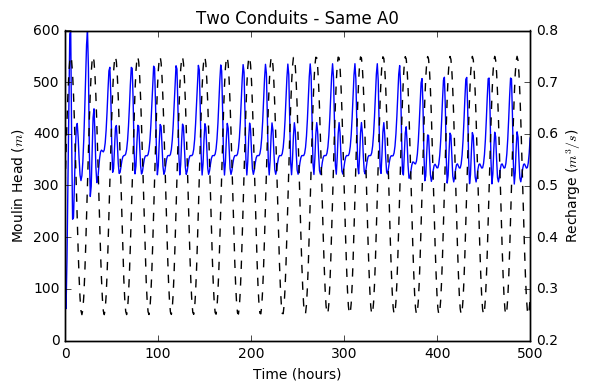

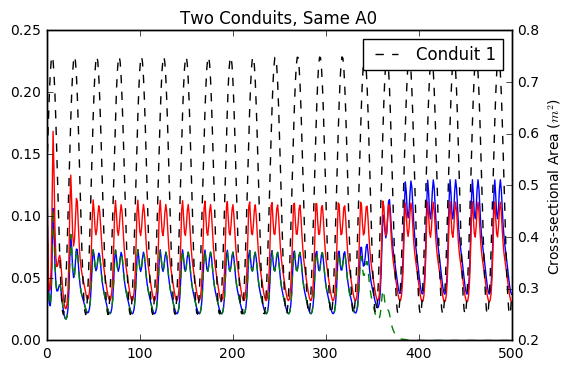

In [13]:
# Clear variables that change

# Find the smallest A0 for all three of them with the same
# Changing ---- 2 conduit below --------
L1=500 # Length of conduit 1
L2=500 # Length of conduit 2
L_merg=100 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.2 # Starting Ac of conduit 2
A0_merg=0.2 # Starting Ac of merged conduit
h0=100 # head in moulin (start)
Recharge=.50 # Average recharge to moulin
A_R=10 # Moulin cross sectional area
Z=1000 # Ice thickness

# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)


Ar = linspace(0.17,0.18,20) #range of A0 to search through
sol2_list = []
Amin2_list = []
for A in Ar:
    sol2_test= odeint(dy_dt2, [h0,A0_1,A0_2,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
    sol2_list.append(sol2_test)
    if max(sol2_test[:,0]) < Z:
        Amin2_list.append(A)
Amin2=min(Amin2_list)



Ar2 = linspace(0.3,0.8,100)
sol2_list2 = []
Amax2_list = []
for A in Ar2:
    sol2_test2= odeint(dy_dt2, [h0,A0_1,A0_2,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
    sol2_list2.append(sol2_test2)
    if max(sol2_test2[:,0]) < Z:
        Amax2_list.append(A)
Amax2 = max(Amax2_list)


print 'Two Conduits Merging with the same A0'
print 'Minimum A0 =',Amin2, 'Max A0 =',Amax2
print 'Conditions: Z =',Z,'Ave Recharge =',Recharge,'A_R =',A_R,'h0 = ',h0  
    
    
    
    
sol2= odeint(dy_dt2, [h0,A0_1,A0_2,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

'''
# CHECK -----
C1 = C(sol2[:,1],L1)
C2 = C(sol2[:,2],L2)
C_merg = C(sol2[:,3],L_merg)
h2 = []
for i,Cblank in enumerate(C1):
    h2.append(brentq(fh2, 0, 10000, args=(sol2[i,0],C1[i],C2[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)
Q2 = C2*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)
Q_merg = C_merg*sqrt(array(h2))
# plot
figure()
plot(t,Q1,t,Q2,t,Q_merg,t,Q1+Q2,'--')
legend(['Conduit 1','Conduit 2','Merged Conduit','Q1+Q2'],loc=1)
xlabel("Time (seconds)")
ylabel("Flux ($m^3/s$)")
'''

# %xdel sol2
# %xdel Ar
# %xdel Ar2
# %xdel sol2_list
# %xdel sol2_list2
# %xdel sol2_test
# %xdel sol2_test2

In [ ]:
# print model run specifications
print 'Two Conduit Model'
print 'Max Head =',max(sol2[:,0]), 'Min Head =',min(sol2[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z
# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol2[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")
title("Two Conduits - Same A0")
# plot Ac
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol2[:,1])
ax1.plot(tplot,sol2[:,2],'--')
ax1.plot(tplot,sol2[:,3])
ax2.plot(tplot,Rec,'k--')
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Merged'],loc=1)
title("Two Conduits, Same A0")



In [6]:
# 2 conduit model - finding minimum A0 for different starting A0


# Changing ---- 2 conduit below --------
L1=5000 # Length of conduit 1
L2=5000 # Length of conduit 2
L_merg=5000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.2 # Starting Ac of conduit 2
A0_merg=0.2 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness

# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)


A1r = linspace(0.01,1,10) #range of A0 to search through for conduit 1
A2r = linspace(0.01,1,10) # range of A0 to search through for conduit 2
Amr = linspace(0.01,1,10) # range of A
sol_list1 = []
sol_list2 = []
sol_list3 = []
Amin_list1 = []
Amin_list2 = []
Amin_list3 = []

for i,A in enumerate(A1r):
    sol_test = odeint(dy_dt2,[h0,A,A2r[i],Amr[i]], t, args=(The Recharge,Z,A_R,L1,L2,L_merg))
    sol_list1.append(sol_test)
#     print 'C1 all',i,A,max(sol_test[:,0])
    if max(sol_test[:,0]) < Z:
        Amin_list1.append(A)
#         print 'C1 if, i=',i,'A=',A
        for ii,AA in enumerate(A2r):
            sol_test2 = odeint(dy_dt2,[h0,A,AA,Amr[i]], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
#             print 'C2 all, i=',i,'A=',A,'ii=',ii,'AA=',AA,'hmax=',max(sol_test2[:,0])
            sol_list2.append(sol_test2)
            if max(sol_test2[:,0]) < Z:
                Amin_list2.append(AA)
#                 print 'C2 if, ii=',ii,'AA=',AA
                for iii,AAA in enumerate(Amr):
                    sol_test3 = odeint(dy_dt2,[h0,A,AA,AAA], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
                    sol_list3.append(sol_test3)
#                     print 'C3 all, i,ii,iii=',i,ii,iii,'A,AA,AAA=',A,AA,AAA,'hmax=',max(sol_test3[:,0])
                    if max(sol_test3[:,0]) < Z:
                        Amin_list3.append(AAA)
#                         print 'C3 if, iii,AAA=',iii,AAA




print 'Two Conduits Merging with the same A0'
print 'Minimum A0 =',Amin2, 'Max A0 =',Amax2
print 'Conditions: Z =',Z,'Ave Recharge =',Recharge,'A_R =',A_R,'h0 = ',h0  
    
    
    
    
sol2= odeint(dy_dt2, [h0,A0_1,A0_2,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L_merg))
Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting
# print model run specifications
print 'Two Conduit Model'
print 'Max Head =',max(sol2[:,0]), 'Min Head =',min(sol2[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z
# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol2[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")
title("Two Conduits - Same A0")
# plot Ac
figure()
plot(tplot,sol2[:,1])
plot(tplot,sol2[:,2],'--')
plot(tplot,sol2[:,3])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Merged'],loc=1)
title("Two Conduits, Same A0")

'''
# CHECK -----
C1 = C(sol2[:,1],L1)
C2 = C(sol2[:,2],L2)
C_merg = C(sol2[:,3],L_merg)
h2 = []
for i,Cblank in enumerate(C1):
    h2.append(brentq(fh2, 0, 10000, args=(sol2[i,0],C1[i],C2[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)
Q2 = C2*sqrt(abs(sol2[:,0]-h2))*sign(sol2[:,0]-h2)
Q_merg = C_merg*sqrt(array(h2))
# plot
figure()
plot(t,Q1,t,Q2,t,Q_merg,t,Q1+Q2,'--')
legend(['Conduit 1','Conduit 2','Merged Conduit','Q1+Q2'],loc=1)
xlabel("Time (seconds)")
ylabel("Flux ($m^3/s$)")
'''

%xdel sol2
%xdel Ar
%xdel Ar2
%xdel sol2_list
%xdel sol2_list2
%xdel sol2_test
%xdel sol2_test2

SyntaxError: invalid syntax (<ipython-input-6-6b5e9a6ebf7a>, line 33)

In [ ]:
Amin_list1

In [ ]:
Amin_list2

In [ ]:
Amin_list3